This notebook demonstrates how different types of Gravitational Wave Background (GWB) strain amplitude calculations are performed.

Consult the following references:
* [Phinney-2001](https://ui.adsabs.harvard.edu/abs/2001astro.ph..8028P/abstract) - A Practical Theorem on Gravitational Wave Backgrounds 
* [Enoki+Nagashima-2007](https://ui.adsabs.harvard.edu/abs/2007PThPh.117..241E/abstract) -  The Effect of Orbital Eccentricity on Gravitational Wave Background Radiation from Supermassive Black Hole Binaries
* [Sesana+2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.390..192S/abstract) - The stochastic gravitational-wave background from massive black hole binary systems: implications for observations with Pulsar Timing Arrays


In [34]:
# MOD 1: needed to append sys path to import holodeck
import sys
sys.path.append('/.')


# %load ../notebooks/init.ipy
%reload_ext autoreload
%autoreload 2

# Builtin packages
from importlib import reload
import logging
import os
from pathlib import Path
import sys
import warnings

# standard secondary packages
import astropy as ap
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats
import tqdm.notebook as tqdm

# development packages
import kalepy as kale
import kalepy.utils
import kalepy.plot

# --- Holodeck ----
import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC, NWTG
import holodeck.gravwaves
import holodeck.evolution
import holodeck.population

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

# Load log and set logging level
log = holo.log
log.setLevel(logging.INFO)

In [24]:
def figax_gwb(**kw):
    kwargs = dict(xlabel='GW Frequency $[\mathrm{yr}^{-1}]$', ylabel='Characteristic Strain')
    kwargs.update(kw)
    fig, ax = plot.figax(**kwargs)
    plot._twin_hz(ax, fs=10)
    return fig, ax

**Define LaTeX macros/commands**

$\newcommand{\mchirp}{\mathcal{M}}$
$\newcommand{\msol}{M_\odot}$

$\newcommand{\lr}[1]{\left({#1}\right)}$
$\newcommand{\lrangle}[1]{\langle{#1}\rangle}$

# Idealized GWB Calculation

## Construct a population of binaries

We will randomly create some number of sample binaries, as a toy model.  From that, we will calculate a number-density distribution of binaries.  Typically, the number density would be calculated directly (e.g. from semi-analytic models), but here we start from a finite population to more easily allow for cross-checking the results.

The number-density distribution can also be used to construct realizations of discrete binary populations, including populations over the full universe.  Because we are not starting from the number-density, we can also cross-check these discretized populations with our starting population.

Set basic parameters

In [25]:
NUM = 1e6                   #: number of starting, sample binaries
MASS_EXTR = [1e6, 1e10]     #: range of total-masses to construct (units of [Msol])

# Specify PTA frequency range of interest
TMAX = (20.0 * YR)          #: maximum observing time in units of [sec]
NFREQS = 100                #: number of frequency bins to consider

In [26]:
# Construct target PTA frequency bins.
fobs_gw = np.arange(1, NFREQS+1) / TMAX     #: frequency bin-centers in units of [Hz]
df = fobs_gw[0] / 2                         #: half of frequency bin-width
fobs_gw_edges = np.concatenate([fobs_gw - df, [fobs_gw[-1] + df]])   #: frequency bin-edges

Construct sample binary population

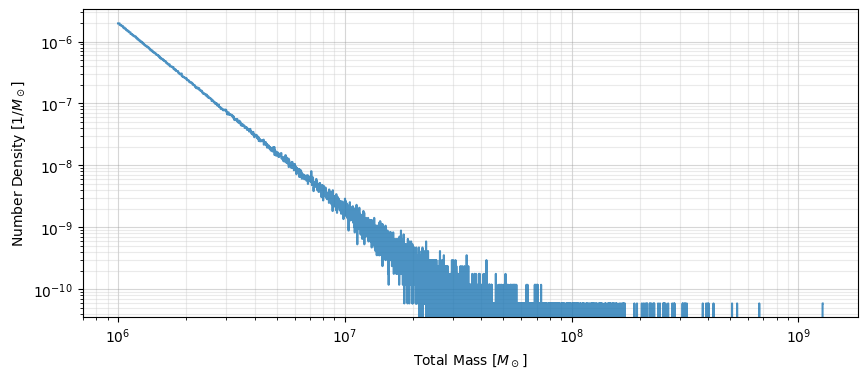

In [27]:
# Construct binary total-masses
MASS_DENS_POWER_LAW = -3           #: power-law index of mass-distribution

# Choose random masses following power-law distribution with given index in number-density
rr = np.random.random(size=int(NUM))
plaw = MASS_DENS_POWER_LAW + 1.0
masses = np.array(MASS_EXTR) ** plaw
masses = (masses[0] + (masses[1] - masses[0])*rr) ** (1./plaw)
masses *= MSOL
del rr

# Set fixed values of redshift and mass-ratio
redz = 0.05      #: redshift of all binaries
mrat = 0.3      #: mass-ratio of all binaries

# Plot mass distributon
fig, ax = plot.figax(xlabel='Total Mass $[M_\odot]$', ylabel='Number Density $[1/M_\odot]$')
kale.dist1d((masses/MSOL), carpet=False, density=False)
plt.show()

Construct a Number-Density distribution of MBH binaries.

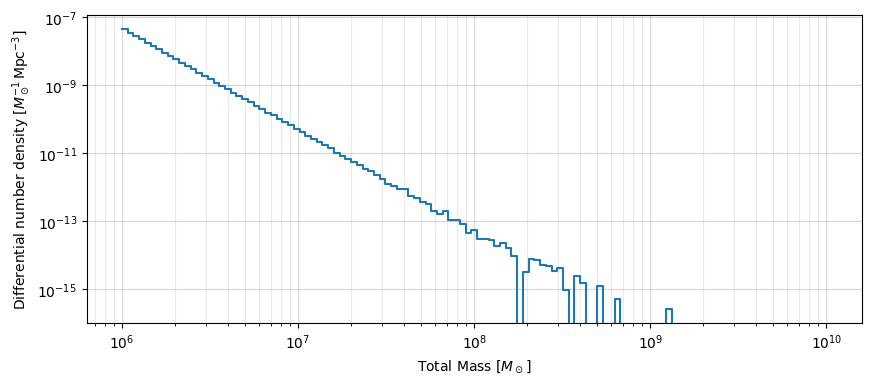

In [28]:
NBINS = 123     #: number of mass-bins for number-density distribution

# mbin_edges = zmath.spacing(masses, 'log', NBINS+1)
mbin_edges = MSOL * np.logspace(*np.log10(MASS_EXTR), NBINS+1)     #: edges of mass-bins, units of [gram]
mbin_cents = 0.5 * (mbin_edges[:-1] + mbin_edges[1:])              #: centers of mass-bins, units of [gram]

# Volume of the Universe out to the given redshift
vcom = cosmo.comoving_volume(redz).cgs.value    #: Comoving volume in units of [cm^3]

# Calculate binary number-density, units of [1/ (cm^3 * g)]
ndens, *_ = sp.stats.binned_statistic(masses, None, statistic='count', bins=mbin_edges)   # histogram the binaries
ndens /= np.diff(mbin_edges)    #: divide by the bin-widths to get number-density
ndens /= vcom                   #: divide by volume to get a comoving volume-density

fig, ax = plot.figax(xlabel='Total Mass [$M_\odot$]', ylabel='Differential number density $[M_\odot^{-1} \, \\mathrm{Mpc}^{-3}]$')
plot.draw_hist_steps(ax, mbin_edges/MSOL, ndens*MSOL*(MPC**3))
plt.show()

## Semi-Analytic (SA) Calculation

The GWB characteristic strain spectrum can be calculated **semi-analytically** using a volumetric number-density of sources $n(M, q, z) = dN/dV_c$, as [Phinney 2001, Eq. 5] or [Enoki & Nagashima 2007, Eq. 3.6]:

$$ h_c^2 = \frac{4G}{\pi c^2 f} \int dM \, dq \, dz \, \frac{d^3 n(M, q, z)}{dM \, dq \, dz} \, \left( \frac{dE_{GW}(M, q)}{d f_r}\right)_{f_r = f(1+z)}$$

Assuming circular, GW-driven orbits, this can be rewritten as [Enoki & Nagashima 2007, Eq.3.11]:

$$ h_c^2 = \frac{4\pi}{3 c^2} (\pi f)^{-4/3} \int dM \, dq \, dz \, \frac{d^3 n(M, q, z)}{dM \, dq \, dz} \, \frac{(G\mathcal{M})^{5/3}}{(1+z)^{1/3}}$$

Typically the number density will be calculated based on observations or phenomenological grounds.  For example, rough estimates of the occurrence rates of binaries, or based on Semi-Analytic or Semi-Empirical Models (SAMs / SEMs) of populations of galaxies, galaxy mergers, and black hole binary populations

Calculate GWB assuming circular, GW-driven evolution

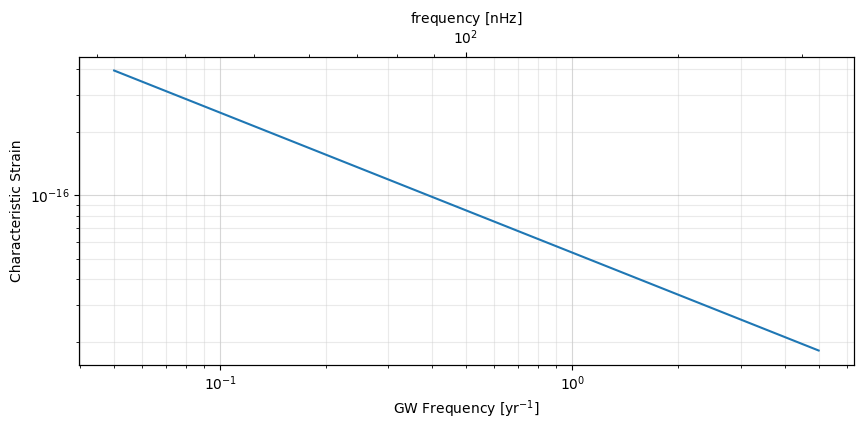

In [29]:
# Get bin-edges in chirp-mass (units of [gram])
mchirp_edges = utils.chirp_mass_mtmr(mbin_edges, mrat)
mchirp_cents = 0.5 * (mchirp_edges[:-1] + mchirp_edges[1:])

# Construct the integrand
integrand = ndens * np.power(NWTG * mchirp_cents, 5.0/3.0) * np.power(1+redz, -1.0/3.0)

# sum over bins
gwb_sa = ((4.0 * np.pi) / (3 * SPLC**2)) * np.power(np.pi*fobs_gw, -4.0/3.0) * np.sum(integrand * np.diff(mbin_edges))
gwb_sa = np.sqrt(gwb_sa)

# plot GWB
xx = fobs_gw * YR
fig, ax = figax_gwb()
ax.plot(xx, gwb_sa)
plt.show()

## Monte Carlo (MC) Calculation

The GWB can also be calculated explicitly from the full population of binaries in the universe [Sesana et al. 2008, Eq.~10], 
$$h_c^2(f) = \int_0^\infty \!\! dM \, dq \, dz \; \frac{d^4 N}{dM \, dq \, dz \, d\ln f_r} \; h^2(f_r),$$

where the spectral GW strain (*not* characteristic strain) for a circular binary is,

$$h(f_r) = \frac{8}{10^{1/2}} \frac{(G\mathcal{M})^{5/3}}{c^4 d_c} (2\pi f_r)^{2/3}.$$

From [Sesana et al. 2008, Eq.6] we can write,

$$\frac{d^4 N}{dM \, dq \, dz \, d\ln f_r} = \frac{d^3 n_c}{dM \, dq \, dz} \frac{dz}{dt} \frac{dt}{d\ln f_r} \frac{d V_c}{dz}.$$

The standard cosmographic relations are [Hogg 1999],

$$\frac{dz}{dt} = H_0 (1+z) E(z) \\
    \frac{d V_c}{dz} = 4\pi \frac{c}{H_0} \frac{d_c^2}{E(z)} \\
    d_L = d_c \, (1+z)$$

Combining these, we obtain:

$$h_c^2(f) = \int_0^\infty \!\! dM \, dq \, dz \; \frac{d^3 n_c}{dM \, dq \, dz} \, h^2(f_r) \, 4\pi c \, d_c^2 (1+z) \, \frac{f_r}{df_r / dt}.$$

The hardening timescale for a circular, GW-driven binary is:

$$\tau_{GW} \equiv \frac{f_r}{\left[df_r/dt\right]_{GW}} = \frac{5}{96} \frac{c^5}{(G \mathcal{M})^{5/3}} (2\pi f_r)^{-8/3}.$$

Plugging this in to the previous relation gives:

$$h_c^2(f) = \frac{20\pi c^6}{96} \int_0^\infty \!\! dM \, dq \, dz \; \frac{d^3 n_c}{dM \, dq \, dz} \, h^2(f_r) \, \frac{d_c^2 (1+z)}{(G \mathcal{M})^{5/3}} (2\pi f_r)^{-8/3}.$$

Note that this is ultimately the same expression as for the Semi-Analytic calculation previously.  But we can use it in a slightly different way.

In [30]:
def gwb_number_from_ndens(ndens, medges, mc_cents, dcom, fro):
    """Convert from binary (volume-)density [dn/dM], to binary number [dN/dM].
    
    Effectively, [Sesana+2008] Eq.6.
    
    """
    # `fro` = rest-frame orbital frequency
    integrand = ((20*np.pi*(SPLC**6))/96) * ndens * np.diff(medges)
    integrand *= (dcom**2) * (1.0 + redz) * np.power(NWTG * mc_cents, -5.0/3.0)
    integrand = integrand[:, np.newaxis] * np.power(2.0*np.pi*fro, -8.0/3.0)
    return integrand

In [31]:
# Convert from observer-frame GW frequency to rest-frame orbital frequency (assuming circular binaries)
frst_orb = fobs_gw[np.newaxis, :] * (1.0 + redz) / 2.0

# Get comoving distance, units of [cm]
dcom = cosmo.comoving_distance(redz).cgs.value

# Calculate spectral strain of binaries at bin-centers
hs_mc = (8.0 / np.sqrt(10)) * np.power(NWTG * mchirp_cents, 5.0/3.0) / (dcom * (SPLC**4))
hs_mc = hs_mc[:, np.newaxis] * np.power(2*np.pi*frst_orb, 2.0/3.0) 

# Get the distribution of number of binaries
integrand = gwb_number_from_ndens(ndens, mbin_edges, mchirp_cents, dcom, frst_orb)

# Sum over bins to get GWB amplitude
gwb_mc = np.sum(integrand * (hs_mc**2), axis=0)
gwb_mc = np.sqrt(gwb_mc)

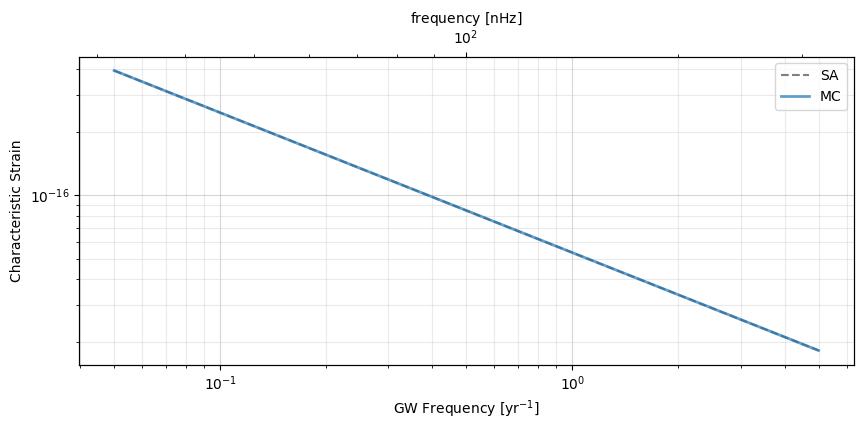

In [32]:
fig, ax = figax_gwb()

xx = fobs_gw * YR
ax.plot(xx, gwb_sa, 'k--', alpha=0.5, label='SA')
ax.plot(xx, gwb_mc, label='MC', lw=2.0, alpha=0.7)

ax.legend()
plt.show()

The "MC" (Monte-Carlo) and "SA" (semi-analytic) calculations should match perfectly so far.  In the following section we will use the "MC" expression to actually perform a Monte-Carlo sampling.

### Discretization / Realization

The previous calculations (both semi-analytic, and the re-written version) assume a smooth continuous distribution of binaries.  Binaries, however, are discrete: the population is composed of individual systems, and there cannot be fractional systems (as is implicitly assumed above).  To correct this, we can discretize our population into integer multiples of binaries.  At the same time, we can also take into account some measure of cosmic variance - in the form of Poisson variations --- which also gives us multiple 'realizations' of the population.  For a given bin of binaries, instead of using the fractional expectation-value number of binaries, we will draw from a Poisson distribution centered around that value.

Note that we are still restricting ourselves to the binned population.  i.e. instead of individual binaries across the parameter space, we are still consider the ``N_i`` binaries in each parameter bin ``i``.  But now we are ensuring that ``N_i`` is an integer, and we can also construct multiple realizations of it.

In [33]:
NREALS = 100    #: choose a number of realizations to model

"""
NOTE: `gwb_number_from_ndens` returns ``dN/dln(f)``.  We want to create realizations based on ``N``
    the actualy number of binaries.  So we multiply by ``Delta ln(f)``, to get the number of
    binaries in each frequency bin (``Delta N_i``).  Then we calculate the discretizations.
    Then we divide by ``Delta ln(f)`` again, to get the number of binaries per frequency bin,
    needed for the GW characteristic strain calculation.
"""

integrand = gwb_number_from_ndens(ndens, mbin_edges, mchirp_cents, dcom, frst_orb)
# get the number of binaries in each frequency bin
integrand = integrand * np.diff(np.log(fobs_gw_edges))

num_exp = np.sum(integrand[:, 0])
print(f"Expected number of binaries in zero freq bin: {num_exp:.4e}")

# Calculate "realizations" by Poisson sampling distribution of binary number
realized = np.random.poisson(integrand[..., np.newaxis], size=integrand.shape + (NREALS,))

# convert back to number of binaries per log-frequency interval, for GWB calculation
realized = realized / np.diff(np.log(fobs_gw_edges))[np.newaxis, :, np.newaxis]

num_real = np.sum(realized[:, 0, :], axis=0)
num_real_ave = np.mean(num_real)
num_real_std = np.std(num_real)
print(f"Realized number of binaries in zero freq bin: {num_real_ave:.4e} ± {num_real_std:.2e}")

# Calculate GWB amplitude
gwb_mc_real = np.sum(realized * (hs_mc**2)[..., np.newaxis], axis=0)
gwb_mc_real = np.sqrt(gwb_mc_real)

Expected number of binaries in zero freq bin: 2.1394e+10


ValueError: lam value too large

In [ ]:
fig, ax = figax_gwb()
xx = fobs_gw * YR
ax.plot(xx, gwb_sa, 'k--', alpha=0.5, label='SA')
ax.plot(xx, gwb_mc, label='MC', lw=2.0, alpha=0.7)

color = 'r'
gwb_mc_med = np.median(gwb_mc_real, axis=-1)
gwb_mc_span = np.percentile(gwb_mc_real, [25, 75], axis=-1)
ax.plot(xx, gwb_mc_med, lw=0.5, color=color)
ax.fill_between(xx, *gwb_mc_span, alpha=0.25, color=color, label='MC realized')

ax.legend()
plt.show()

## Finite Population Calculation

The number density was calculated from a finite number of binaries, in a finite volume.  Instead of going through the number-density as an intermediate quantity (i.e. binning sample binaries), just use the finite number of binaries directly to calculate the GWB.

$$
    \frac{d^3 n_c}{dM \, dq \, dz} \, dM \, dq \, dz
        \rightarrow \frac{1}{V_c} \sum_i  \delta(M < M_i < M + \Delta M) \cdot \delta(q < q_i < q + \Delta q) \cdot \delta(z < z_i < z + \Delta z) \, F(M, q, z) \\
        \rightarrow \frac{1}{V_c} \sum_i F(M_i \,,\, q_i \,,\, z_i)
$$

In [ ]:
dcom = cosmo.comoving_distance(redz).cgs.value
frst_orb = fobs_gw[np.newaxis, :] * (1.0 + redz) / 2.0
mchirp = utils.chirp_mass_mtmr(masses, mrat)

hs_fin = (8.0 / np.sqrt(10)) * np.power(NWTG * mchirp, 5.0/3.0) / (dcom * (SPLC**4))
hs_fin = hs_fin[:, np.newaxis] * np.power(2*np.pi*frst_orb, 2.0/3.0) 

integrand = ((20*np.pi*(SPLC**6))/96) / vcom
integrand *= (dcom**2) * (1.0 + redz) * np.power(NWTG * mchirp, -5.0/3.0)
integrand = integrand[:, np.newaxis] * np.power(2.0*np.pi*frst_orb, -8.0/3.0)

gwb_fin = np.sum(integrand * (hs_fin**2), axis=0)
gwb_fin = np.sqrt(gwb_fin)

In [ ]:
fig, ax = figax_gwb()
xx = fobs_gw * YR
ax.plot(xx, gwb_sa, 'k--', label='SA', alpha=0.5, lw=2.0)
ax.plot(xx, gwb_mc, lw=2.0, alpha=0.7, label='MC')
ax.plot(xx, gwb_fin, lw=2.0, alpha=0.75, label='Finite')

ax.legend()
plt.show()

### Discretization / Realization

In a similar way to the MC calculation above, we can discretize and calculate multiple realizations from the starting finite population.  This is a little strange: we start with a finite population, and then construct multiple, new discrete populations from this.  There is a key difference from the starting populations and the new ones: the starting population represents only a fixed volume, while the realizations are very explicitly full Universes.  In this example, the difference is trivial, but if the starting population comes from a finite volume (for example a cosmological hydrodynamic simulation), then the difference is much more important (and useful).

In [ ]:
# NOTE: this is quite slow, so only construct a single realization!
DISCRETIZE_FINITE_FLAG = True

if DISCRETIZE_FINITE_FLAG:

    _dlnf = np.diff(np.log(fobs_gw_edges))
    real = np.random.poisson(integrand * _dlnf) / _dlnf
    gwb_fin_real = np.sum(real * (hs_fin**2), axis=0)
    gwb_fin_real = np.sqrt(gwb_fin_real)

    fig, ax = figax_gwb()
    xx = fobs_gw * YR
    ax.plot(xx, gwb_sa, 'k--', alpha=0.5, label='SA')
    ax.plot(xx, gwb_fin, lw=3.0, alpha=0.6, ls=':', label='Finite')
    col, = ax.plot(xx, gwb_mc_med, lw=2.0, alpha=0.7, label='MC realized')
    col = col.get_color()
    ax.fill_between(xx, *gwb_mc_span, alpha=0.25, color=col, label='MC realized')

    color = 'r'
    ax.plot(xx, gwb_fin_real, lw=0.75, color=color, alpha=0.5, label='Finite realized')

    ax.legend()
    plt.show()

# IN DEVELOPMENT / TESTING ::

## (Re)Sampling Binned Population

In the MC method, we 'discretized' the population to account for finite number effects and Poisson sampling (i.e. a model for cosmic variance).  This was still done to the distribution of binaries in a bin-wise fashion: we would get a 'discretized' number of binaries per bin, for each realization.

Here we will construct populations that attempt to better Monte-Carlo sample the binary parameter space.  This is done using the `kalepy.sample_outliers` function.  The idea is that the most interesting parts of parameter space are the bins with expectation values for order-unity binaries, i.e.$\lrangle{N_i} \sim 1$.  The motivation is that bins with $\lrangle{N_i} \ll 1$ are unlikely to ever produce binaries, and bins with $\lrangle{N_i} \gg 1$ are accurately represented by the bin-centroid value, instead of sampling individual binaries explicitly.  The `kalepy.sample_outliers` function thus returns weighted bin-centroids above some critical expectation value, and samples individual binaries for bins below that critical value.

The function call looks like, `kalepy.sample_outliers(edges, density, threshold, mass=None)`.  The arguments are as follows:
* `edges` : the grid-edges of the parameter space being sampled.  This is a list of arrays, with one array for each dimension of the space.
* `density` : the number-density, evaluated at grid-edges, that is sampled from.  
* `threshold` : the number of binaries per-bin, below which each binary is sampled.  Bins above this value will return a weighted centroid.  Bins below this value will return the appropriate number of individual binaries each with weight equal to unity.
* `mass` : the number of binaries that should be sampled in each bin.  This is an optional argument, and if it is not provided, then `density` is integrated over to calculate `mass`.

The return values are `vals, weights` which are:
* `vals` : the samples binary parameters, shaped `(D, S)` for `D` dimensions of parameter space, and `S` total number of samples - including both individual binaries, and grid centroids.
* `weights` : the weight of each sample, either equal to unity for individual binaries (i.e. for bins below the sampling threshold), or equal to the bin-mass (for bins above the sampling threshold).

NOTE: sampling the population is somewhat delicate and must be done with care!  See additional notes below.

In [ ]:
def extrap_cents_to_edges(grid):
    ndim = grid.ndim
    vals = np.copy(grid)

    # Extrapolate to one more point each left and right, along each axis progressively
    # (A,B,C,...) ==> (A+2,B,C,...) ==> (A+2,B+2,C,...) ==>  ...  ==> (A+2, B+2, C+2, ...)
    for ax in range(ndim):
        vals = np.moveaxis(vals, ax, 0)
        ll = 2*vals[0] - vals[1]
        rr = 2*vals[-1] - vals[-2]
        vals = np.concatenate([[ll], vals, [rr]], axis=0)
        vals = np.moveaxis(vals, 0, ax)

    # Interpolate to mid-points along each axis
    # (A+2,B+2,C+2,...) ==> (A+1,B+2,C+2,...) ==> (A+1,B+1,C,...) ==>  ...  ==> (A+1, B+1, C+1, ...)
    for ax in range(ndim):
        vals = np.moveaxis(vals, ax, 0)
        vals = 0.5 * (vals[:-1] + vals[1:])
        vals = np.moveaxis(vals, 0, ax)

    return vals

In [ ]:
_df = frst_orb[0, 0]
frst_orb_edges = np.concatenate([frst_orb[0] - _df/2, [frst_orb[0][-1] + _df/2]])

number_resamp = gwb_number_from_ndens(ndens, mbin_edges, mchirp_cents, dcom, frst_orb)
number_resamp *= np.diff(np.log(fobs_gw_edges))
print(f"{number_resamp.sum()=:.4e}")

# Convert to differential-density number
sample_ndens = number_resamp / np.diff(mbin_edges)[:, np.newaxis]
sample_ndens = sample_ndens / np.diff(frst_orb_edges)[np.newaxis, :]
sample_ndens = extrap_cents_to_edges(sample_ndens)

### Sample Full Grid

This section uses the `kalepy.sample_grid` method to sample *ALL* binaries.  This is extremely slow, and memory intensive.  For large-enough number of binaries, it will likely crash.  Use with caution, and only when the total number of binaries being samples is within the capabilities of the computer -- typically $\lrangle{N_\mathrm{total}} \lesssim 10^7$ or so.

In [ ]:
SAMPLE_FULL_FLAG = False

In [ ]:
NREALS = 10

#!!! NOTE: this is *prohibitively* slow !!!#

if SAMPLE_FULL_FLAG:
    log.warning("!SAMPLING FULL POPULATION IS REALLY SLOW AND MEMORY INTENSIVE!")
    gwb_resamp_full = np.zeros((fobs_gw.size, NREALS))

    for ii in utils.tqdm(range(NREALS)):
        sample_edges = [np.log10(mbin_edges), np.log(frst_orb_edges)]
        vals = kale.sample_grid(sample_edges, sample_ndens, mass=number_resamp)
        mm = 10.0 ** vals[0]
        frorb = np.e ** vals[1]

        dcom = cosmo.comoving_distance(redz).cgs.value
        mchirp = utils.chirp_mass_mtmr(mm, mrat)

        hs = (8.0 / np.sqrt(10)) * np.power(NWTG * mchirp, 5.0/3.0) / (dcom * (SPLC**4))
        hs = hs * np.power(2*np.pi*frorb, 2.0/3.0) 

        sepa_isco = 6 * NWTG * mm / SPLC**2
        frst_orb_isco = utils.kepler_freq_from_sepa(mm, sepa_isco)
        bads = frorb > frst_orb_isco
        merged = np.ones_like(bads, dtype=float)
        merged[bads] = 0.0

        fogw = frorb * 2.0 / (1.0 + redz)
        hs = merged * (hs**2)
        gwb_resamp_full[:, ii], *_ = sp.stats.binned_statistic(fogw, hs, statistic='sum', bins=fobs_gw_edges)
        gwb_resamp_full[:, ii] = np.sqrt(gwb_resamp_full[:, ii])

In [ ]:
if SAMPLE_FULL_FLAG:

    fig, ax = plot.figax()
    xx = fobs_gw * YR
    ax.plot(xx, gwb_sa, 'k--', lw=1.5, alpha=0.5)
    ax.plot(xx, gwb_fin, 'k:', lw=2.0, alpha=0.5)
    gwb_mc_med = np.median(gwb_mc, axis=-1)
    ax.plot(xx, gwb_mc_med, color='b', lw=2.0, alpha=0.5)

    med = np.median(gwb_resamp_full, axis=-1)
    ax.plot(xx, med, lw=0.5, color='r')
    ax.fill_between(xx, *np.percentile(gwb_resamp_full, [25, 75], axis=-1), alpha=0.5, color='r')

    tw = ax.twinx()
    tw.plot(xx, gwb_sa/med, 'r--', alpha=0.5)
    tw.plot(xx, gwb_mc_med/med, 'b--', alpha=0.5)
    plt.show()

### Sample 'Outliers'

Outlier sampling must be performed carefully, as it can be delicate.  Keep in mind some of the following considerations:
* bin centroids are used for bins above the threshold.  The number of bins in the distribution must be sufficiently high such that the centroids are good approximations for the true distribution of values.
* consider whether to sample in linear or log space for different parameters.  For example, **for the GWB calculation, sampling mass in linear-space produces better results** and it produces centroids nearer to the strain-weighted mass.

In [ ]:
NREALS = 100

gwb_resamp_out = np.zeros((fobs_gw.size, NREALS))
sample_threshold = 1e2

DOWN = 10.0

temp = np.copy(number_resamp) / DOWN

for ii in utils.tqdm(range(NREALS)):
    # sample_edges = [np.log10(mbin_edges), np.log(frst_orb_edges)]
    # vals, weights = kale.sample_outliers(sample_edges, sample_ndens, sample_threshold, mass=number_resamp) 
    # mm = 10.0 ** vals[0]
    # frorb = np.e ** vals[1]
    
    sample_edges = [mbin_edges, frst_orb_edges]
    vals, weights = kale.sample_outliers(sample_edges, sample_ndens, sample_threshold, mass=temp)
    mm = vals[0]
    frorb = vals[1]
    weights = weights * DOWN

    dcom = cosmo.comoving_distance(redz).cgs.value
    mchirp = utils.chirp_mass_mtmr(mm, mrat)

    hs = (8.0 / np.sqrt(10)) * np.power(NWTG * mchirp, 5.0/3.0) / (dcom * (SPLC**4))
    hs = hs * np.power(2*np.pi*frorb, 2.0/3.0) 

    fogw = frorb * 2.0 / (1.0 + redz)

    hs_1 = (hs**2) * weights
    gwb_resamp_out[:, ii], *_ = sp.stats.binned_statistic(fogw, hs_1, statistic='sum', bins=fobs_gw_edges)
    gwb_resamp_out[:, ii] = gwb_resamp_out[:, ii] / np.diff(np.log(fobs_gw_edges))

gwb_resamp_out = np.sqrt(gwb_resamp_out)


In [ ]:
fig, ax = plot.figax()
xx = fobs_gw * YR
ax.plot(xx, gwb_sa, 'k--', lw=1.5, alpha=0.5, label='SA')
ax.plot(xx, gwb_fin, 'k:', lw=2.0, alpha=0.5, label='Finite')

color = 'b'
ax.plot(xx, gwb_mc_med, lw=0.5, color=color)
ax.fill_between(xx, *gwb_mc_span, alpha=0.25, color=color, label='MC realized')

color = 'r'
gwb_resamp_med = np.median(gwb_resamp_out, axis=-1)
gwb_resamp_span = np.percentile(gwb_resamp_out, [25, 75], axis=-1)
ax.plot(xx, gwb_resamp_med, lw=0.5, color=color, alpha=0.5)
ax.fill_between(xx, *gwb_resamp_span, alpha=0.25, color=color, label='Resample')

ax.legend()
plt.show()

In [ ]:
fig, ax = plot.figax(yscale='linear', ylabel='Ratio (Resamp/MC)')

cc, = ax.plot(xx, gwb_resamp_med/gwb_mc_med, alpha=0.5, label='Median')
ax.scatter(xx, gwb_resamp_med/gwb_mc_med, alpha=0.25, color=cc.get_color(), marker='.', s=50)
ax.plot(xx, (gwb_resamp_span/gwb_mc_span).T, alpha=0.5, label='Interquartile Boundaries')

ax.legend
plt.show()